In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import product
import optuna
import os
from typing import Dict, List, Tuple, Any
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
display(HTML("<style>.output_scroll {height: 300px; overflow-y: scroll;}</style>"))
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'sans-serif',
    'font.size': 12
})

## 1. Research Objectives and Background
This study aims to explore how intrinsic metrics (such as RankMe, CLID, etc.) can guide the automated selection of dimensionality reduction methods and model optimization, thereby improving the performance of downstream tasks such as classification and clustering. By analyzing the relationship between intrinsic metrics and model performance after dimensionality reduction, we evaluate their generalizability across different datasets and domains, providing both theoretical and practical support for representation learning and automated machine learning.

## 2. Datasets
We try to evaluate the intric metric using the data of different dimensions, below dataset from UCI is selected applying to our experiment. 
- Iris (4D), Wine (13D), Breast Cancer (30D), Digits (64D), Olivetti Faces (400D), Synthetic Clusters (20D).
- All data are standardized.

In [ ]:
# load datasets with different dimensions
def load_datasets():
    """
    load various datasets with different dimensions for evaluation
    """
    datasets = {}
    
    # 1. Iris
    iris = load_iris()
    datasets['Iris'] = {
        'data': iris.data,
        'target': iris.target,
        'feature_names': iris.feature_names
    }
    
    # 2. Wine
    wine = load_wine()
    datasets['Wine'] = {
        'data': wine.data,
        'target': wine.target,
        'feature_names': wine.feature_names
    }
    
    # 3. Breast Cancer
    cancer = load_breast_cancer()
    datasets['Breast Cancer'] = {
        'data': cancer.data,
        'target': cancer.target,
        'feature_names': cancer.feature_names
    }
    
    # 4. Synthetic Clusters (dim: 20)
    synthetic_data, synthetic_labels = make_blobs(
        n_samples=300, centers=4, n_features=20, 
        cluster_std=1.5, random_state=42
    )
    datasets['Synthetic Clusters'] = {
        'data': synthetic_data,
        'target': synthetic_labels,
        'feature_names': [f'feature_{i}' for i in range(20)]
    }
    # 5. Handwritten Digits (dim: 1797 * 64)
    from sklearn.datasets import load_digits
    digits = load_digits()
    datasets['Digits'] = {
        'data': digits.data,  
        'target': digits.target,
        'feature_names': [f'pixel_{i}' for i in range(64)]
    }
     # 6. Olivetti Faces (dim: 400)
    try:
        from sklearn.datasets import fetch_olivetti_faces
        faces = fetch_olivetti_faces(shuffle=True, random_state=42)
        # only take first 2000 samples to control computation time
        datasets['Olivetti Faces'] = {
            'data': faces.data[:2000],  # 2000样本, 400特征 (20x20像素)
            'target': faces.target[:2000],
            'feature_names': [f'pixel_{i}' for i in range(400)]
        }
       #print("successfully load Olivetti Faces dataset (dim:400)")
    except Exception as e:
        print(f"fail to load Olivetti Faces dataset: {e}")

    # 8. Spambase (dim: 58)
    try:
        spambase = fetch_openml('spambase', version=1, as_frame=True)
        
        # 处理数据
        spambase_data = spambase.data.values
        spambase_target = spambase.target.values
        
        # 将字符串标签转换为数值
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        spambase_target_encoded = le.fit_transform(spambase_target)
        
        datasets['Spambase'] = {
            'data': spambase_data,
            'target': spambase_target_encoded,
            'feature_names': spambase.feature_names if hasattr(spambase, 'feature_names') else [f'feature_{i}' for i in range(spambase_data.shape[1])]
        }
        #print(f"successfully load Spambase dataset: {spambase_data.shape}")
        
    except Exception as e:
        print(f"fail to load Spambase dataset: {e}")

    #9. German Credit(dim: 20)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
    columns = [
        "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount", "Savings", "EmploymentSince",
        "InstallmentRate", "PersonalStatusSex", "OtherDebtors", "PresentResidence", "Property", "Age",
        "OtherInstallmentPlans", "Housing", "ExistingCredits", "Job", "NumPeopleLiable", "Telephone", "ForeignWorker", "Target"
    ]

    german = pd.read_csv(url, sep=' ', header=None, names=columns)
    # convert categorical features to numerical
    for col in german.columns[:-1]:  
        if german[col].dtype == 'object':
            le = LabelEncoder()
            german[col] = le.fit_transform(german[col])
    datasets['German Credit'] = {
        'data': german.iloc[:, :-1].values,
        'target': german.iloc[:, -1].values,
        'feature_names': columns[:-1]
    }
    return datasets


def preprocess_data(data):
    """
    Standardize the dataset
    """
    scaler = StandardScaler()
    return scaler.fit_transform(data)

## 3. Methods
- **Dimensionality reduction**: PCA, t-SNE, UMAP, with parameter grids automatically adapted to data shape.
- **Internal metrics**: RankMe, CLID, Participation Ratio, Effective Rank, Alignment, Uniformity.
- **Classification evaluation**: Cross-validation with multiple classifiers on reduced features, recording accuracy.
- **Parameter optimization**: Supports grid search and Bayesian optimization, with automatic parameter sampling.
- **Correlation analysis**: Analyzes the relationship between RankMe score and classification accuracy.

### 3.1 Evaluate the dimensionality reduction with internal metric and classification

In [99]:
def rankme(embeddings, epsilon=1e-12):
    """
    Compute the RankMe score of an embedding matrix.

    Parameters:
    -----------
    embeddings : numpy.ndarray, shape (n_samples, n_features)
        Input embedding matrix, each row is a sample vector.
    epsilon : float, default=1e-12
        Numerical stability parameter to avoid log(0)
    Returns:
    --------
    rankme_score : float
        RankMe score, range from 1 to n_samples
    """
    if embeddings.shape[0] <= 1:
        return 1.0
    # 1. L2 normalize each sample vector
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # avoid division by zero
    normalized_embeddings = embeddings / norms
    # 2. Compute cosine similarity matrix
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
    # 3. Convert similarity to probability distribution (softmax)
    temperature = 0.1
    similarity_matrix = similarity_matrix / temperature
    exp_sim = np.exp(similarity_matrix - np.max(similarity_matrix, axis=1, keepdims=True))
    probabilities = exp_sim / np.sum(exp_sim, axis=1, keepdims=True)
    # 4. Compute entropy for each row
    probabilities = np.clip(probabilities, epsilon, 1.0)
    entropy_per_sample = -np.sum(probabilities * np.log(probabilities), axis=1)
    # 5. RankMe score is the exponential of the mean entropy
    rankme_score = np.exp(np.mean(entropy_per_sample))
    return rankme_score

In [ ]:
# define different evaluation function
def clid_score(embeddings, k=10, epsilon=1e-12):
    """
    compute CLID score 
    
    Parameters:
    -----------
    embeddings : numpy.ndarray, shape (n_samples, n_features)
        embeddings matrix
    k : int, default=10
        number of nearest neighbors
    epsilon : float, default=1e-12
        small constant for numerical stability
        
    Returns:
    --------
    clid_score : float
        CLID score
    """
    n_samples, n_features = embeddings.shape
    
    if n_samples <= k + 1:
        return 1.0

    # 1. compute k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    
    # 2. exclude the first column (distance to itself)
    distances = distances[:, 1:] 
    # 3. compute local intrinsic dimension estimates
    local_dims = []
    for i in range(n_samples):
        dists = distances[i]
        dists = dists[dists > epsilon]  # remove zero distances
        
        if len(dists) < 2:
            local_dims.append(1.0)
            continue

        # use distance ratios to estimate local dimension
        # ID estimation: based on Maximum Likelihood Estimation
        log_ratios = np.log(dists[1:] / dists[0] + epsilon)
        if len(log_ratios) > 0:
            local_dim = np.mean(log_ratios) / np.log(2)
            local_dims.append(max(1.0, local_dim))
        else:
            local_dims.append(1.0)
    
    # 4. 返回平均局部内在维度
    lid = np.mean(local_dims)
    gid = participation_ratio(embeddings)
    gid1 = effective_rank(embeddings)
    return lid + gid + gid1


def alignment_uniformity(embeddings, alpha=2):
    """
    compute Alignment and Uniformity scores (Wang & Isola, 2020)
    
    Parameters:
    -----------
    embeddings : numpy.ndarray, shape (n_samples, n_features)
        normalized embeddings
    alpha : float, default=2
        uniformity exponent parameter
        
    Returns:
    --------
    alignment : float
       alignment score Lower is better
    uniformity : float
        uniformity score Lower is better
    """
    # Normalized embedding vector
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)
    normalized = embeddings / norms
    
    n_samples = embeddings.shape[0]

    # compute uniformity
    # uniformity = log(E[exp(-t||z_i - z_j||^2)])
    pairwise_sq_dists = np.sum((normalized[:, None, :] - normalized[None, :, :]) ** 2, axis=2)
    uniformity = np.log(np.mean(np.exp(-alpha * pairwise_sq_dists)))
    
    # For alignment, we need positive sample pairs, here we use all sample pairs as an approximation
    # In practice, this should be based on the true labels or semantic similarity of the data
    alignment = np.mean(pairwise_sq_dists)
    
    return alignment, uniformity

def participation_ratio(embeddings):
    """
    compute participation ratio (Participation Ratio)
    """
    # compute covariance matrix
    cov_matrix = np.cov(embeddings.T)
    eigenvals = np.linalg.eigvals(cov_matrix)
    eigenvals = np.real(eigenvals[eigenvals > 1e-12])
    
    if len(eigenvals) == 0:
        return 0
    
    # participation_ratio = (sum of eigenvals)^2 / sum of eigenvals^2
    return (np.sum(eigenvals)**2) / np.sum(eigenvals**2)


def effective_rank(embeddings, epsilon=1e-12):
    """
    compute Effective Rank of the embedding matrix
    """
    # SVD decomposition
    U, s, Vt = np.linalg.svd(embeddings, full_matrices=False)
    
    # normalize singular values
    s_normalized = s / np.sum(s)
    s_normalized = s_normalized[s_normalized > epsilon]
    
    if len(s_normalized) == 0:
        return 1.0
    
    # compute entropy
    entropy = -np.sum(s_normalized * np.log(s_normalized))
    
    # effective rank
    return np.exp(entropy)


def clustering_quality_metrics(embeddings, n_clusters=None):
    """
    compute clustering quality metrics
    """
    from sklearn.cluster import KMeans
    from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
    
    n_samples = embeddings.shape[0]
    if n_clusters is None:
        n_clusters = min(10, max(2, n_samples // 20))
    
    if n_clusters >= n_samples or n_clusters < 2:
        return {'silhouette': 0, 'calinski_harabasz': 0, 'davies_bouldin': float('inf')}
    
    try:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        
        silhouette = silhouette_score(embeddings, labels)
        calinski = calinski_harabasz_score(embeddings, labels)
        davies_bouldin = davies_bouldin_score(embeddings, labels)
        
        return {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies_bouldin
        }
    except:
        return {'silhouette': 0, 'calinski_harabasz': 0, 'davies_bouldin': float('inf')}

In [101]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
def classification_evaluation(embeddings, labels, cv=5, random_state=42):
    """
    Evaluate classification performance using StratifiedKFold cross-validation.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=random_state, n_estimators=100),
        'SVM': SVC(random_state=random_state, kernel='rbf')
    }
    results = {}
    best_score = -float('inf')
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for clf_name, clf in classifiers.items():
        cv_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []
        for train_idx, test_idx in skf.split(embeddings, labels_encoded):
            X_train, X_test = embeddings[train_idx], embeddings[test_idx]
            y_train, y_test = labels_encoded[train_idx], labels_encoded[test_idx]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cv_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
            precision_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
            recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        mean_score = np.mean(cv_scores)
        if mean_score > best_score:
            best_score = mean_score
            best_classifier = clf_name
            results['best_accuracy'] = mean_score
            results['best_classifier'] = clf_name
        results[f'{clf_name}_accuracy'] = mean_score
        results[f'{clf_name}_f1'] = np.mean(f1_scores)
        results[f'{clf_name}_precision'] = np.mean(precision_scores)
        results[f'{clf_name}_recall'] = np.mean(recall_scores)
    return results


def comprehensive_evaluation_with_classification(embeddings, labels, name="Unknown",print = False):
    """
    comprehensive evaluation of embeddings including intrinsic metrics and classification performance.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        embedding matrix
    labels : numpy.ndarray
        true labels
    name : str
        dataset name

    Returns:
    --------
    results : dict
        evaluation results
    """
        
    
    results = {}
    
    try:
        # 1. representation quality metrics
        results['rankme'] = rankme(embeddings)
        
        results['clid'] = clid_score(embeddings)
        
        # results['intrinsic_dim'] = intrinsic_dimension_mle(embeddings)
        # print(f"intrinsic_dim: {results['intrinsic_dim']:.4f}")
        
        results['participation_ratio'] = participation_ratio(embeddings)
        
        results['effective_rank'] = effective_rank(embeddings)
        
        alignment, uniformity = alignment_uniformity(embeddings)
        results['alignment'] = alignment
        results['uniformity'] = uniformity

        if print is True:
            print(f"\n=== {name} evaluation results ===")
            print(f"RankMe score: {results['rankme']:.4f}")
            print(f"CLID score: {results['clid']:.4f}")
            print(f"participation_ratio: {results['participation_ratio']:.4f}")
            print(f"effective_rank: {results['effective_rank']:.4f}")
            print(f"alignment: {alignment:.4f}")
            print(f"uniformity: {uniformity:.4f}")
        
        # 2. classification performance
        if labels is not None and len(np.unique(labels)) > 1:
            classification_results = classification_evaluation(embeddings, labels)
            results.update(classification_results)

            #   print classification results
            # print("\n--- classification performance ---")
            for key, value in classification_results.items():
                if 'accuracy' in key:
                    classifier_name = key.replace('_accuracy', '')
                    # print(f"{classifier_name} accuracy: {value:.4f}")

        # 3. clustering quality
        # clustering_metrics = clustering_quality_metrics(embeddings)
        # results.update(clustering_metrics)
        # print(f"Davies-Bouldin score: {clustering_metrics['davies_bouldin']:.4f}")

    except Exception as e:
        print(f"appearing error during the evaluation: {e}")
        # default values
        default_keys = ['rankme', 'clid', 'intrinsic_dim', 'participation_ratio', 
                       'effective_rank', 'alignment', 'uniformity', 'silhouette',
                       'calinski_harabasz', 'davies_bouldin']
        
        # default classification metrics
        classifiers = ['Logistic Regression', 'Random Forest', 'SVM']
        metrics = ['accuracy', 'f1', 'precision', 'recall']
        for clf in classifiers:
            for metric in metrics:
                default_keys.append(f'{clf}_{metric}')
        
        for key in default_keys:
            if key not in results:
                results[key] = 0 if key != 'davies_bouldin' else float('inf')
    
    return results

In [102]:
# apply dimension reduction
def apply_dimension_reduction(data, method='pca', **params):
    """
    apply different dimension reduction techniques    
    Parameters:
    -----------
    data : numpy.ndarray
    method : str
        reduction method   ：'pca', 'tsne', 'umap'
    n_components : int
    **kwargs : dict        
    Returns:
    --------
    reduced_data : numpy.ndarray
    """
    if method.lower() == 'pca':
        reducer = PCA(random_state=42, **params)
        return reducer.fit_transform(data)
    
    elif method.lower() == 'tsne':
        # 对于t-SNE，需要处理method参数冲突
        tsne_params = params.copy()
        if 'tsne_method' in tsne_params:
            tsne_params['method'] = tsne_params.pop('tsne_method')
        # 如果params中有method参数，这是t-SNE的内部参数
        # 直接传递给TSNE构造函数
        reducer = TSNE(random_state=42, **tsne_params)
        return reducer.fit_transform(data)
    
    elif method.lower() == 'umap':
        reducer = umap.UMAP(random_state=42, **params)
        return reducer.fit_transform(data)
    
    else:
        raise ValueError(f"Applying a unknown method: {method}")

## 3.2 Apply bayesian search and grid search to see What happened under different hyperparameter

In [103]:
def create_parameter_grids(data):
    """Define parameter grids for each dimensionality reduction method"""
    n_features = data.shape[1]
    n_samples = data.shape[0]
    pca_params = {
        'n_components': [x for x in [2, 3, 4, 5, 10, 20, 30, 50] if x < n_features],
        'whiten': [True, False],
        'svd_solver': ['auto', 'full', 'arpack', 'randomized']
    }
    tsne_params = {
        'n_components': [x for x in [2, 3] if x < n_features],
        'perplexity': [5, 10, 20, 30, 50],
        'learning_rate': [10, 50, 100, 200, 500, 1000],
        'max_iter': [250, 500, 1000, 2000],
        'init': ['random', 'pca'],
        'tsne_method': ['exact']
    }
    # for n in tsne_params['n_components']:
    #     if n <= 3:
    #         tsne_params['tsne_method'] = ['barnes_hut', 'exact']
    #     else:
    #         tsne_params['tsne_method'] = ['exact']
    umap_params = {
        'n_components': [x for x in [2, 3, 4, 5, 10, 15, 20, 25, 30, 50] if x < n_features],
        'n_neighbors': [5, 10, 15, 20, 30, 50],
        'min_dist': [0.0, 0.1, 0.25, 0.5, 0.8, 1.0],
        'metric': ['euclidean', 'manhattan', 'chebyshev'],
        'spread': [0.5, 1.0, 2.0],
        'learning_rate': [0.5, 1.0, 2.0],
        'init': ['spectral', 'random'],
        'low_memory': [True, False]
    }
    return {
        'pca': pca_params,
        'tsne': tsne_params,
        'umap': umap_params
    }

In [104]:
# Bayesian optimization for dimensionality reduction hyperparameters
import optuna

def bayesian_optimization(data, dataset_name, labels, reduction_method='pca', n_trials=30):
    """
    Bayesian optimization for hyperparameters of dimensionality reduction methods using Optuna.
    """
    param_grids = create_parameter_grids(data)
    param_grid = param_grids[reduction_method.lower()]
    
    def objective(trial):
        params = {}
        for key, values in param_grid.items():
            if isinstance(values[0], bool):
                params[key] = trial.suggest_categorical(key, values)
            elif isinstance(values[0], str):
                params[key] = trial.suggest_categorical(key, values)
            elif isinstance(values[0], int):
                params[key] = trial.suggest_int(key, min(values), max(values))
            elif isinstance(values[0], float):
                params[key] = trial.suggest_float(key, min(values), max(values))
            else:
                params[key] = trial.suggest_categorical(key, values)
        # check if the parameter is valid
        if reduction_method.lower() == 'umap'and 'min_dist' in params and 'spread' in params and params['min_dist'] > params['spread']:
            return evaluation_results.get('best_accuracy', 0)
                    #raise optuna.exceptions.TrialPruned("min_dist must be less than or equal to spread")
        try:
            reduced_data = apply_dimension_reduction(data, method=reduction_method, **params)
            evaluation_results = comprehensive_evaluation_with_classification(
                reduced_data, labels, f"{dataset_name} (method: {reduction_method})"
            )
            return evaluation_results.get('best_accuracy', 0)
        except Exception as e:
            raise optuna.exceptions.TrialPruned(str(e))
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    best_params = study.best_params
    best_score = study.best_value
    # 收集所有试验结果
    all_trials = []
    for t in study.trials:
        trial_result = t.params.copy()
        trial_result['score'] = t.value
        all_trials.append(trial_result)
    result = {
        'best_params': best_params,
        'best_accuracy': best_score,
        'method': reduction_method,
        'all_trials': all_trials
    }
    return result


In [105]:
def grid_search_optimization(data, dataset_name, labels, reduction_method='pca', max_combinations=100):
    """
    Grid search optimization for hyperparameters of dimensionality reduction methods, with tqdm progress bar.
    """
    from sklearn.model_selection import ParameterGrid
    from tqdm import tqdm
    param_grids = create_parameter_grids(data)
    param_grid = param_grids[reduction_method.lower()]
    all_combinations = list(ParameterGrid(param_grid))
    if len(all_combinations) > max_combinations:
        import random
        random.seed(42)
        combinations = random.sample(all_combinations, max_combinations)
    else:
        combinations = all_combinations
    all_trials = []
    for i, params in enumerate(tqdm(combinations, desc=f'Grid Search ({reduction_method})')):
       
        if reduction_method.lower() == 'umap' and 'min_dist' in params and 'spread' in params and params['min_dist'] > params['spread']:     
            continue
        try:
            reduced_data = apply_dimension_reduction(
                data, method=reduction_method, **params
            )
            evaluation_results = comprehensive_evaluation_with_classification(
                reduced_data, labels, f"{dataset_name} (method: {reduction_method})"
            )
            result = {
                'rankme': evaluation_results.get('rankme', 0),
                'clid': evaluation_results.get('clid', 0),
                'intrinsic_dim': evaluation_results.get('intrinsic_dim', 0),
                'participation_ratio': evaluation_results.get('participation_ratio', 0),
                'effective_rank': evaluation_results.get('effective_rank', 0),
                'alignment': evaluation_results.get('alignment', 0),
                'uniformity': evaluation_results.get('uniformity', 0),
                'logistic_accuracy': evaluation_results.get('Logistic Regression_accuracy', 0),
                'rf_accuracy': evaluation_results.get('Random Forest_accuracy', 0),
                'svm_accuracy': evaluation_results.get('SVM_accuracy', 0),
                'best_classifier_accuracy': evaluation_results.get('best_accuracy', 0),
                'method': reduction_method,
                'params': params,
                'accuracy': evaluation_results.get('best_accuracy', 0),
                'n_components': params.get('n_components', None)
            }
            all_trials.append(result)
        except Exception as e:
            print(f"Failed combination {i+1}: {e}")
            continue
    return all_trials


## 4 Experiment
### 4.1 define the experiment process

In [106]:
def run_with_classification_and_hyperparameter_search(reduction_methods= ['pca'], optimization_type='bayesian',dataset_name = ["iris"] , n_trials=50):
    """
    Run comprehensive experiments with classification performance and hyperparameter optimization.
    """
    datasets = load_datasets()
    all_results = []
    all_original_results = []
    print("====Begin to run comprehensive experiments including classification performance====")
    # used_datasets = ['Iris', 'Wine', 'Breast Cancer', 'Synthetic Clusters', 'Digits', 'Olivetti Faces']
    used_datasets = dataset_name
    for dataset_name, dataset in datasets.items():
        if dataset_name not in used_datasets:
            continue
        print(f"\nProcessing dataset: {dataset_name}")
        print(f"original shape: {dataset['data'].shape}")
        
        # standardize data
        data = preprocess_data(dataset['data'])
        labels = dataset['target']
        
        # evaluate original data
        original_results = comprehensive_evaluation_with_classification(
            data, labels, f"{dataset_name} (Original)"
        )
        original_results['dataset'] = dataset_name
        original_results['method'] = 'Original'
        original_results['dimensions'] = data.shape[1]
        all_original_results.append(original_results)
        
        # apply hyperparameter optimization for each reduction method
        for method in reduction_methods:
            if optimization_type == 'bayesian':
                result = bayesian_optimization(data, dataset_name,labels, method, n_trials)
            elif optimization_type == 'grid':
                results = grid_search_optimization(data, dataset_name,labels, method)
                # Get best result
                best_result = max(results, key=lambda x: x['accuracy'])
                result = {
                    'best_params': best_result['params'],
                    'best_accuracy': best_result['accuracy'],
                    'method': method,
                    'all_trials': results
                }
            result['dataset'] = dataset_name
            result['original_dims'] = data.shape[1]
            all_results.append(result)
    return all_results, all_original_results



### 4.2 Define the plot function 

In [107]:
def create_all_trials_visualization(results, save_path=None):
    """
    Display all trial results, with evaluation metrics on the x-axis and accuracy on the y-axis.
    Different colors represent different dimensionality reduction methods (PCA, t-SNE, UMAP).
    """
    # Process all trial data
    all_trials_data = []
    
    for result in results:
        if isinstance(result, dict):
            dataset = result.get('dataset', 'Unknown')
            method = result.get('method', 'Unknown')
            
            if method == 'Original':
                continue
           
            all_trials = result.get('all_trials', pd.DataFrame())
            if not isinstance(all_trials, pd.DataFrame):
                all_trials = pd.DataFrame(all_trials)
            if not all_trials.empty:
               
                trials_copy = all_trials.copy()
                trials_copy['dataset'] = dataset
                trials_copy['method'] = method
                all_trials_data.append(trials_copy)
    if not all_trials_data:
        print("Don't have any trial data to visualize.")
        return
    # 合并所有试验数据
    df = pd.concat(all_trials_data, ignore_index=True)
    eval_metrics = ['rankme', 'clid', 'alignment', 'effective_rank']
    available_metrics = [metric for metric in eval_metrics if metric in df.columns and df[metric].sum() > 0]
    print(f"avaliable metrics: {available_metrics}")
    print(f"total experiment number: {len(df)}")
    datasets = df['dataset'].unique()
    method_colors = {
        'pca': 'blue',
        'tsne': 'red',
        'umap': 'green'
    }
    for dataset in datasets:
        dataset_data = df[df['dataset'] == dataset]
        if len(dataset_data) == 0:
            continue
        n_metrics = len(available_metrics)
        n_cols = min(3, n_metrics)
        n_rows = (n_metrics + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_metrics == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        for metric_idx, metric in enumerate(available_metrics):
            row = metric_idx // n_cols
            col = metric_idx % n_cols
            ax = axes[row, col] if n_rows > 1 else axes[col]
            for method in ['pca', 'tsne', 'umap']:
                method_data = dataset_data[dataset_data['method'] == method]
                if len(method_data) > 0:
                    x_values = method_data[metric].values
                    y_values = method_data['accuracy'].values
                    valid_mask = ~(np.isnan(x_values) | np.isnan(y_values))
                    x_valid = np.array(x_values)[valid_mask]
                    y_valid = np.array(y_values)[valid_mask]
                    if len(x_valid) > 0:
                        ax.scatter(x_valid, y_valid,
                                   color=method_colors.get(method, 'gray'),
                                   alpha=0.6,
                                   s=30,
                                   label=method.upper())
                        # compute and plot regression line
                        if len(x_valid) > 1:
                            z = np.polyfit(x_valid, y_valid, 1)
                            p = np.poly1d(z)
                            x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
                            ax.plot(x_line, p(x_line), linestyle="--", color=method_colors.get(method, 'gray'), alpha=0.8, linewidth=2)
                            corr = np.corrcoef(x_valid, y_valid)[0, 1]
                            # display corr 
                            x_text = x_valid.min() + 0.7 * (x_valid.max() - x_valid.min())
                            y_text = p(x_text)
                            ax.text(x_text, y_text, f"r={corr:.2f}", color=method_colors.get(method, 'gray'), fontsize=16, fontweight='bold', va='bottom')
            ax.set_xlabel(f'{metric.replace("_", " ").title()} Score')
            ax.set_ylabel('Accuracy')
            ax.grid(True, alpha=0.3)
            if metric_idx == 0:
                ax.legend()
        for idx in range(n_metrics, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            if n_rows > 1:
                axes[row, col].set_visible(False)
            else:
                axes[col].set_visible(False)
        plt.suptitle(f'{dataset} - All Trials: Evaluation Metrics vs Accuracy', fontsize=16)
        plt.tight_layout()
        if save_path:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            filename = f"{dataset}_all_trials_visualization.png"
            filepath = os.path.join(save_path, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"Image saved successfully: {filepath}")
        plt.show()


### 4.2 Experiment with low dimension data Iris

According to the result, under Iris dataset, except the clid score which has a relatively high corrletion between the accuracy and effective rank score ( but maybe due to the trail point is not as many as other internal metrics), tsne and umap are not observed with any corr with the internal metrics

====Begin to run comprehensive experiments including classification performance====

Processing dataset: Iris
original shape: (150, 4)


Grid Search (umap): 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]



Create all trials visualization
avaliable metrics: ['rankme', 'clid', 'alignment', 'effective_rank']
total experiment number: 197
Image saved successfully: Iris/Iris_all_trials_visualization.png
Image saved successfully: Iris/Iris_all_trials_visualization.png


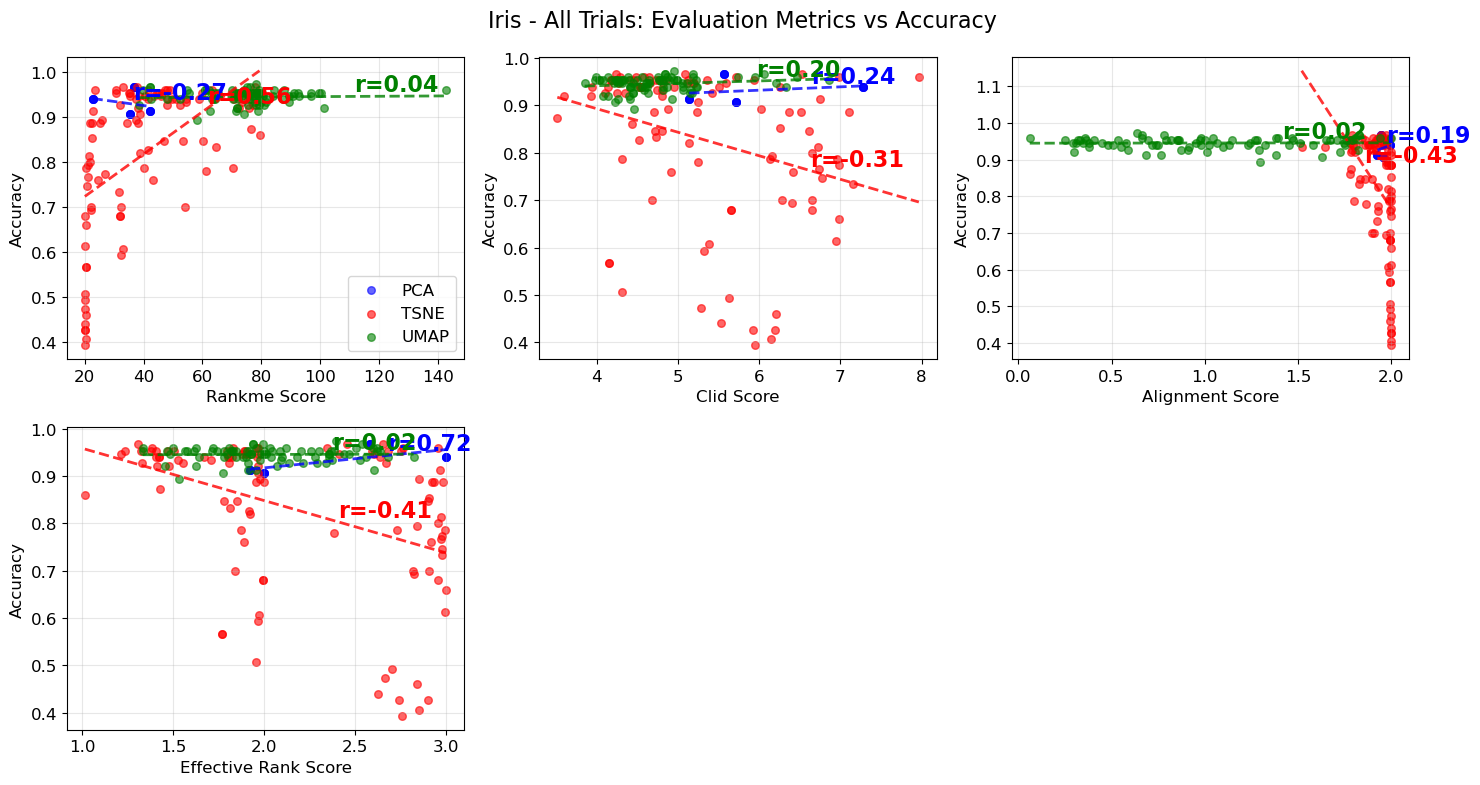

In [109]:
available_datasets = ['Iris', 'Wine', 'Breast Cancer', 'Synthetic Clusters', 'Digits', 'Olivetti Faces','German Credit']
save_directory = "Iris"
dataset_name = "Iris"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
evaluation_results, original_results = run_with_classification_and_hyperparameter_search(reduction_methods= ['pca','tsne','umap'], 
                                                                                      dataset_name=dataset_name,                                                                                      
                                                                                      optimization_type='grid')

# 运行所有试验的可视化
print("Create all trials visualization")
create_all_trials_visualization(evaluation_results, save_path=save_directory)

# print("\nCreate combined all trials plot")
# create_combined_all_trials_plot(evaluation_results, save_path=save_directory)

# print("\nCreate method comparison plot")
# create_method_comparison_plot(evaluation_results, save_path=save_directory)

### 4.3 Experiment with dataset of Wine
The results are similar to those observed on the Iris dataset. In particular, for t-SNE, there appears to be little to no relationship between classification accuracy and the internal metrics—improvements in accuracy do not correspond to changes in the internal metric values. In contrast, for UMAP, the trend is reversed: as the internal metric values increase, the classification accuracy remains largely unchanged, indicating a lack of clear association between these metrics and downstream performance. pca has the best perfermance, its result increased compare to the Iris


====Begin to run comprehensive experiments including classification performance====

Processing dataset: Wine
original shape: (178, 13)


Grid Search (umap): 100%|██████████| 100/100 [00:42<00:00,  2.37it/s]



Create all trials visualization
avaliable metrics: ['rankme', 'clid', 'alignment', 'effective_rank']
total experiment number: 227
Image saved successfully: Wine/Wine_all_trials_visualization.png
Image saved successfully: Wine/Wine_all_trials_visualization.png


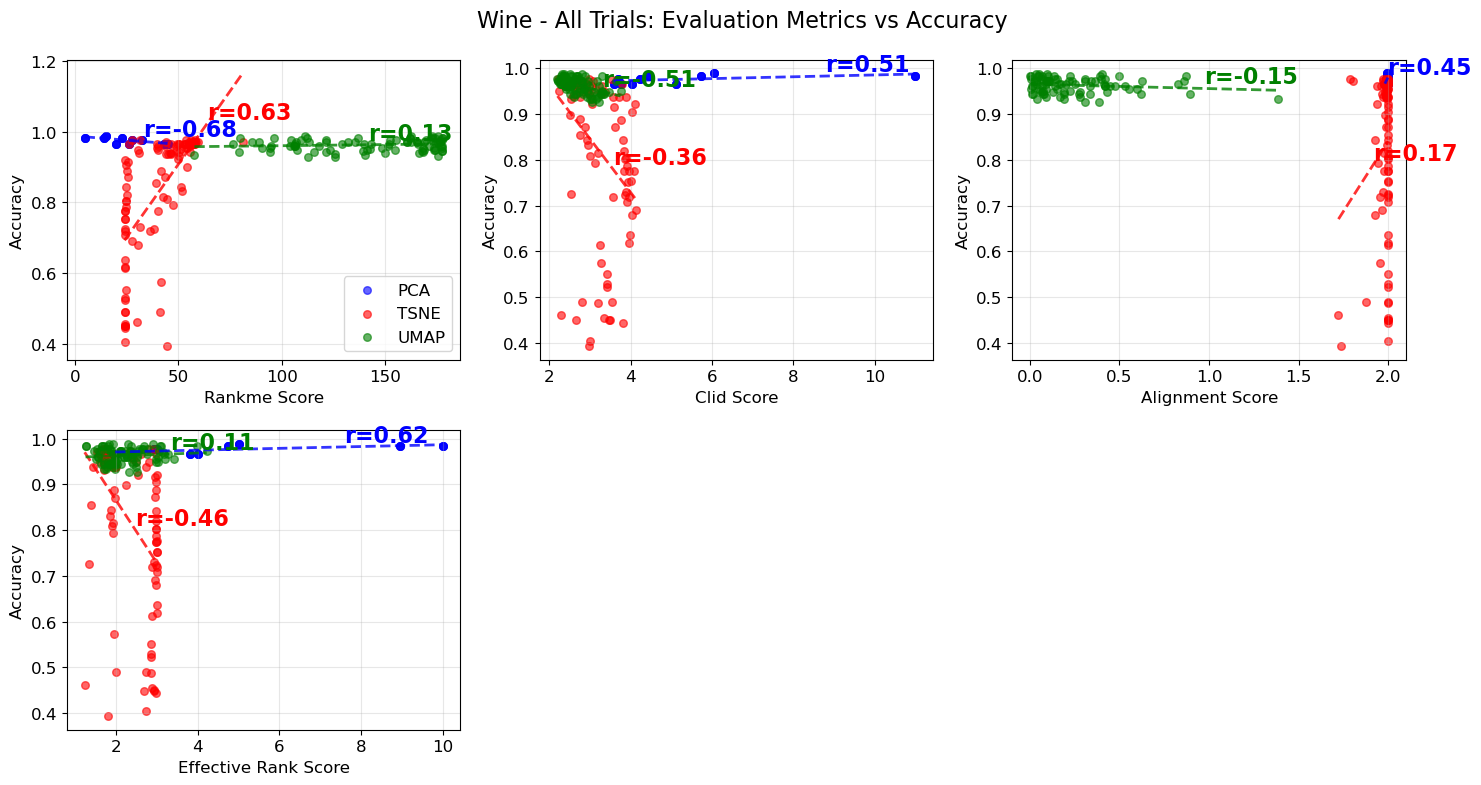

In [ ]:
available_datasets = ['Iris', 'Wine', 'Breast Cancer', 'Synthetic Clusters', 'Digits', 'Olivetti Faces','German Credit']
save_directory = "Wine"
dataset_name = "Wine"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
evaluation_results, original_results = run_with_classification_and_hyperparameter_search(reduction_methods= ['pca','tsne','umap'], 
                                                                                      dataset_name=dataset_name,                                                                                      
                                                                                      optimization_type='grid')
print("Create all trials visualization")
create_all_trials_visualization(evaluation_results, save_path=save_directory)

### 4.4 Experiment with dataset of Breast Cancer

====Begin to run comprehensive experiments including classification performance====

Processing dataset: Breast Cancer
original shape: (569, 30)


Grid Search (umap): 100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


Create all trials visualization
avaliable metrics: ['rankme', 'clid', 'alignment', 'effective_rank']
total experiment number: 233
Image saved successfully: Breast_Cancer/Breast Cancer_all_trials_visualization.png


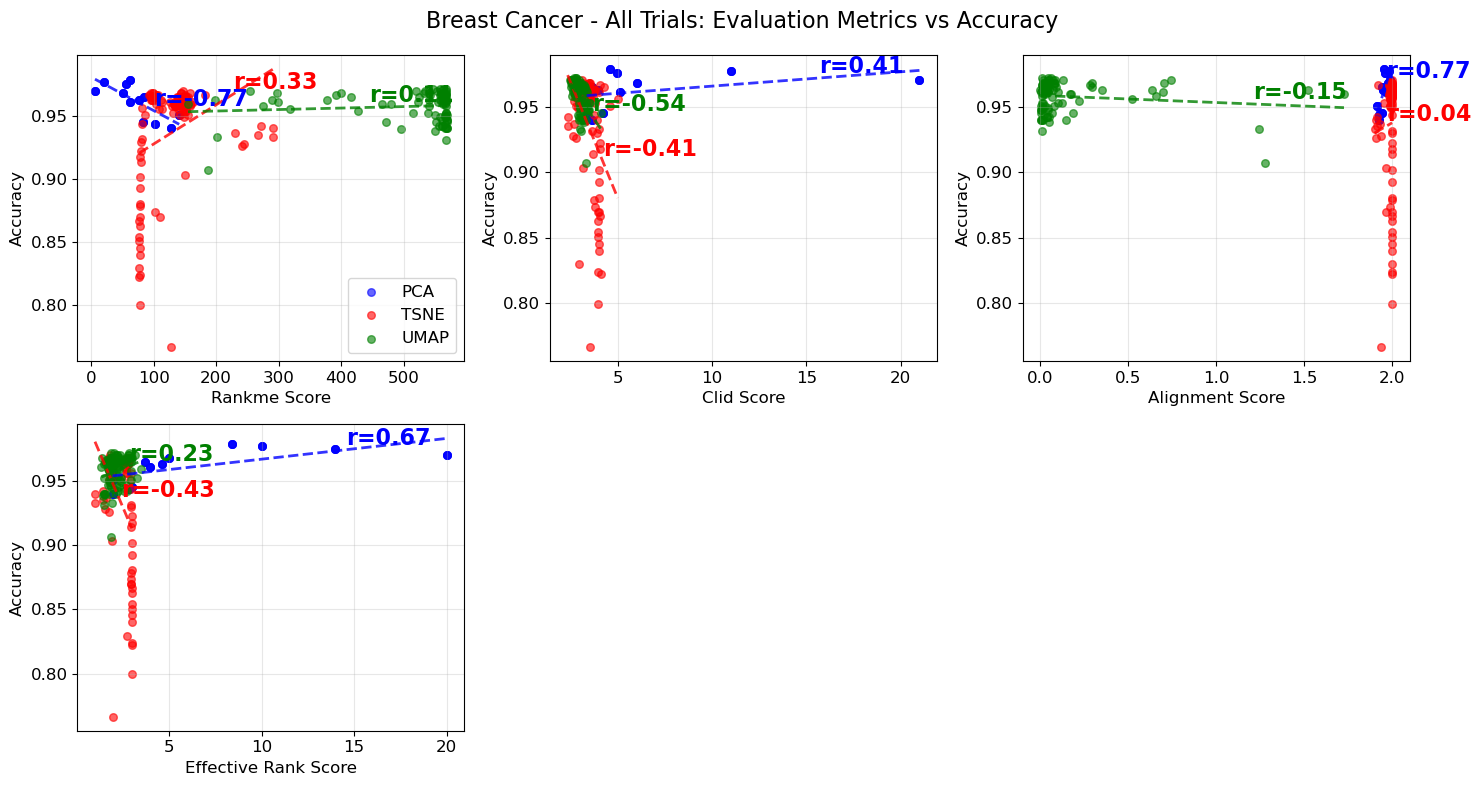

In [ ]:
save_directory = "Breast_Cancer"
dataset_name = "Breast Cancer"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
evaluation_results, original_results = run_with_classification_and_hyperparameter_search(reduction_methods= ['pca','tsne','umap'], 
                                                                                      dataset_name=dataset_name,                                                                                      
                                                                                      optimization_type='grid')
print("Create all trials visualization")
create_all_trials_visualization(evaluation_results, save_path=save_directory)

### 4.5 Experiment with dataset of Digits 

====Begin to run comprehensive experiments including classification performance====

Processing dataset: German Credit
original shape: (1000, 20)


Grid Search (umap): 100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


Create all trials visualization
avaliable metrics: ['rankme', 'clid', 'alignment', 'effective_rank']
total experiment number: 232
Image saved successfully: German_Credit/German Credit_all_trials_visualization.png


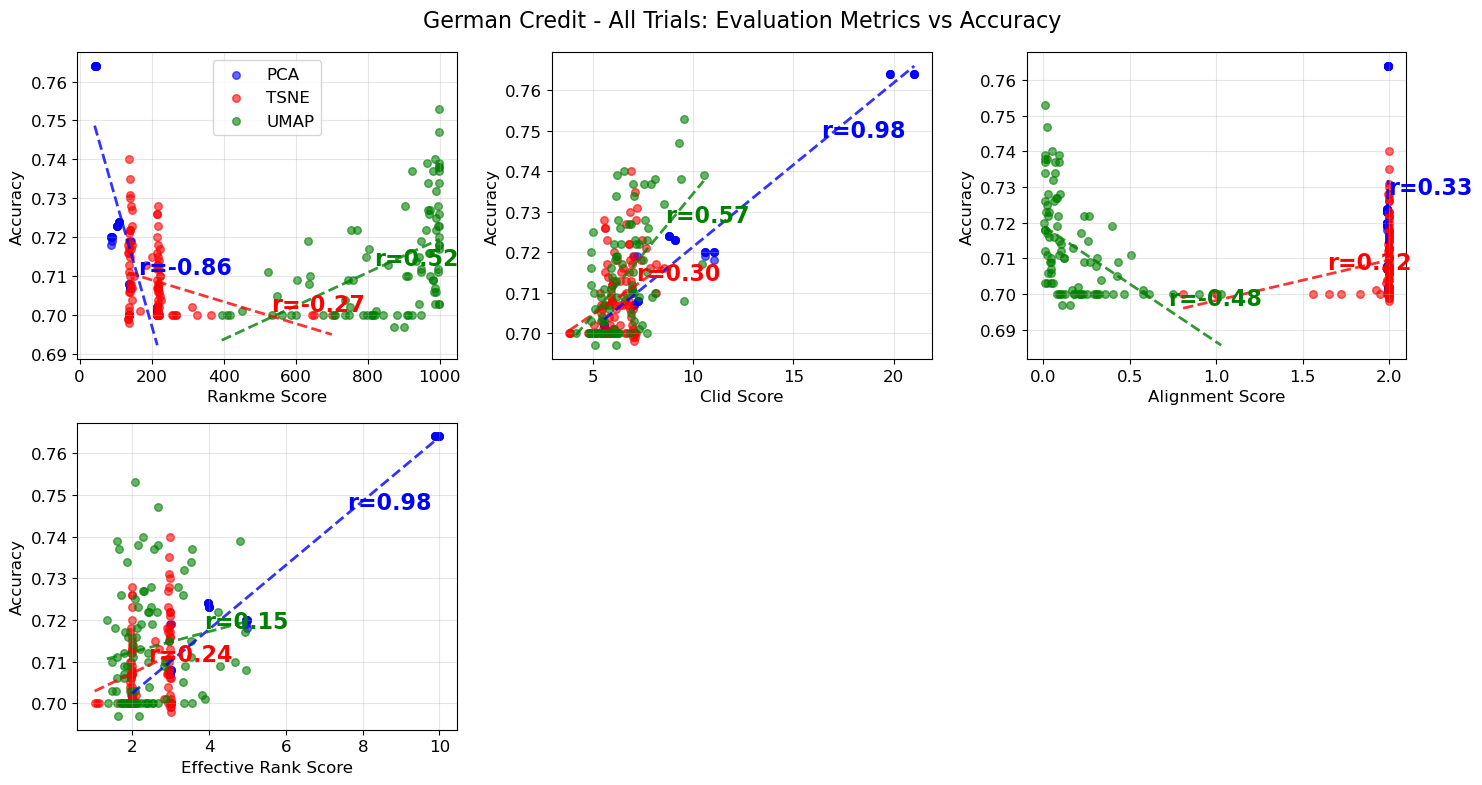

In [ ]:
save_directory = "German_Credit"
dataset_name = "German Credit"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
evaluation_results, original_results = run_with_classification_and_hyperparameter_search(reduction_methods= ['pca','tsne','umap'], 
                                                                                      dataset_name=dataset_name,                                                                                      
                                                                                      optimization_type='grid')
print("Create all trials visualization")
create_all_trials_visualization(evaluation_results, save_path=save_directory)

### 4.6 Experiment with dataset of Olivetti Faces
For this dataset, all internal metric values exhibit a relatively strong linear relationship with accuracy after applying PCA, which is even more pronounced than in the previous dataset. Moreover, as the dimensionality increases, it seems that the linear correlation between internal metrics and accuracy becomes increasingly evident with the PCA reduction method. however.

====Begin to run comprehensive experiments including classification performance====

Processing dataset: Olivetti Faces
original shape: (400, 4096)


Grid Search (umap): 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Create all trials visualization
avaliable metrics: ['rankme', 'clid', 'alignment', 'effective_rank']
total experiment number: 248
Image saved successfully: Olivetti_Faces/Olivetti Faces_all_trials_visualization.png


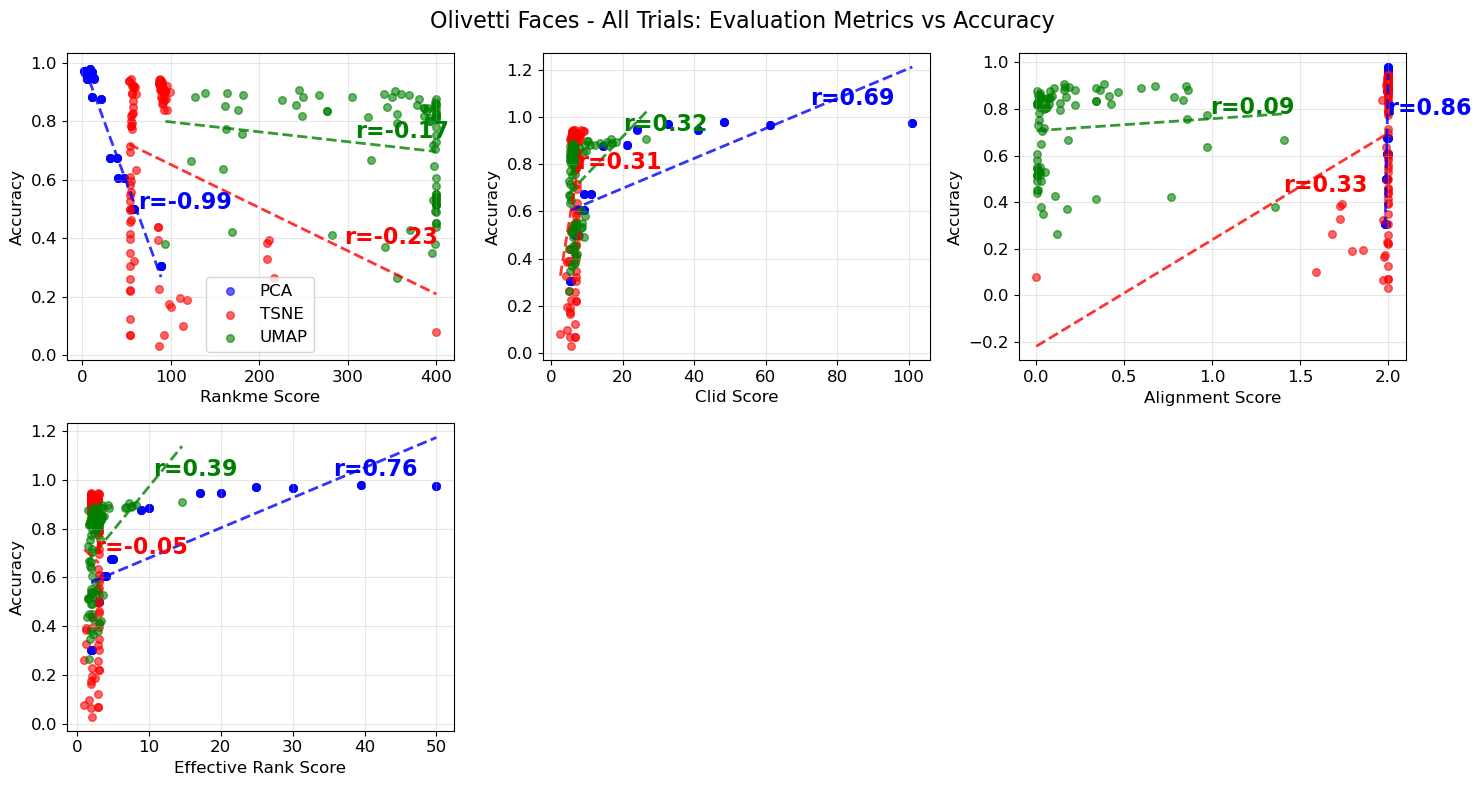

In [ ]:
save_directory = "Olivetti_Faces"
dataset_name = "Olivetti Faces"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
evaluation_results, original_results = run_with_classification_and_hyperparameter_search(reduction_methods= ['pca','tsne','umap'], 
                                                                                      dataset_name=dataset_name,                                                                                      
                                                                                      optimization_type='grid')
print("Create all trials visualization")
create_all_trials_visualization(evaluation_results, save_path=save_directory)

## 5 Conclusion and Future work

## 5.1 Conclusion

- Internal metrics (such as RankMe and CLID) show strong linear correlations with classification accuracy after PCA dimensionality reduction, especially on high-dimensional datasets. This suggests that these metrics can effectively reflect the expressive power of features after PCA dimensionality reduction and downstream classification performance.
- After t-SNE and UMAP dimensionality reduction, the correlation between internal metrics and classification accuracy is weaker. this may due to their different optimization objectives, focusing more on local structure or visualization, which may not necessarily be beneficial for classification tasks.
- Different dimensionality reduction methods significantly affect the relationship between internal metrics and classification performance. Choosing the appropriate method and evaluation metric depends on the specific task and data.


## 5.2 Future work

- Try replacing the classification task with a clustering task to investigate whether the type of downstream task leads to any differences in the results.
- Investigate whether this type of correlation is related to specific datasets.
- RankMe exhibits a outstanding linear relationship with the accuary after dateset being processed by pca, we could Investigate whether this correlation is generalizable across other datasets and domains



